<h1 style="font-family: Arial, sans-serif; font-weight: bold; background: linear-gradient(90deg, rgba(232,130,24,1) 0%, rgba(255,232,149,1) 49%, rgba(124,80,0,1) 100%);color: black; padding: 10px; border-radius: 5px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); text-align: left; margin-top: 20px;"><strong><centre> Introduction 📌 </centre></strong></h1>

> Student performance, student progress and student potential are critical for measuring learning results, selecting learning materials and learning activities. So Let's make a python dashboard to nalyze how students performed, which factors would affect their performance, in which way students can make progress, and whether students have potential to perform better.

<h1 style="font-family: Arial, sans-serif; font-weight: bold; background: linear-gradient(90deg, rgba(232,130,24,1) 0%, rgba(255,232,149,1) 49%, rgba(124,80,0,1) 100%); color: black; padding: 10px; border-radius: 5px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); text-align: left; margin-top: 20px;"><strong><centre> Project Preview 🌟 </centre></strong></h1>

Let's see the project demo before proceeding to the main code and explainations!

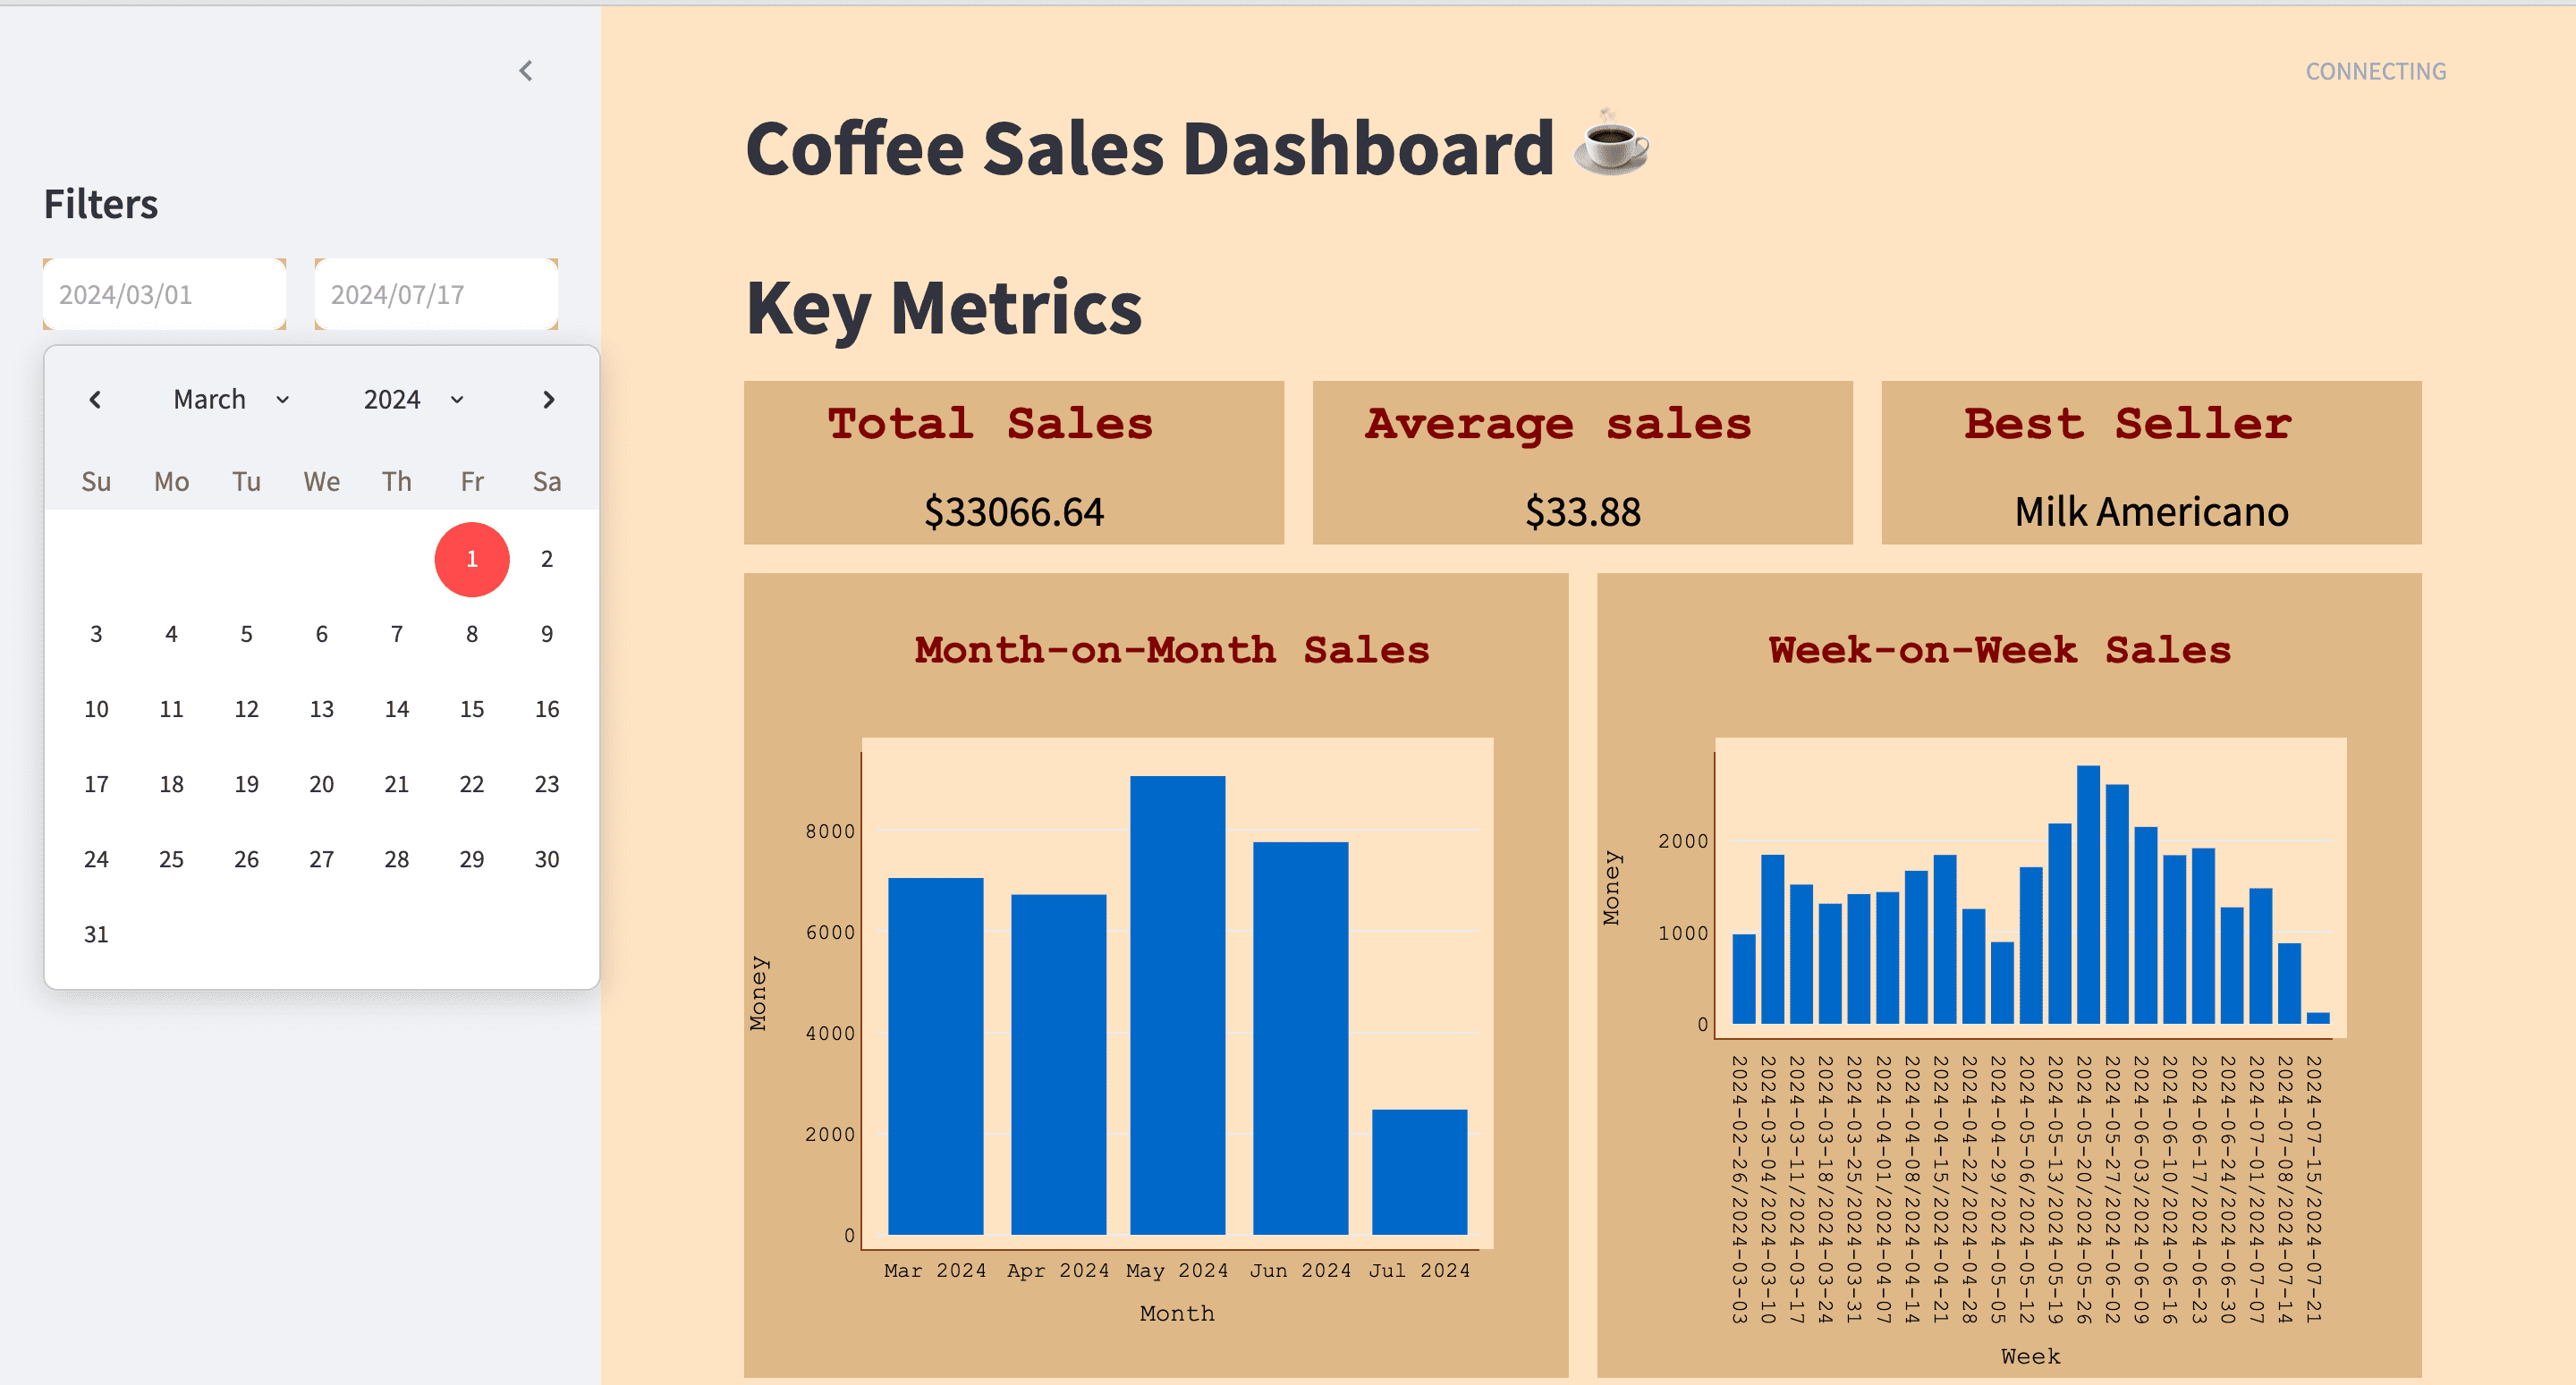

<h1 style="font-family: Arial, sans-serif; font-weight: bold; background: linear-gradient(90deg, rgba(232,130,24,1) 0%, rgba(255,232,149,1) 49%, rgba(124,80,0,1) 100%); color: black; padding: 10px; border-radius: 5px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); text-align: left; margin-top: 20px;"><strong><centre> Importing Libraries & Packages 📚 </centre></strong></h1>

In [ ]:
# install packages
!pip install pyngrok -q
!pip install streamlit -q

In [ ]:
import os
from threading import Thread
from pyngrok import ngrok
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("NGROK_API")

# Add your ngrok token here
ngrok.set_auth_token(secret_value_0)

<h1 style="font-family: Arial, sans-serif; font-weight: bold; background: linear-gradient(90deg, rgba(232,130,24,1) 0%, rgba(255,232,149,1) 49%, rgba(124,80,0,1) 100%); color: black; padding: 10px; border-radius: 5px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); text-align: left; margin-top: 20px;"><strong><centre> Project Configuration 🌐 </centre></strong></h1>

In [4]:
%%writefile requirements.txt

streamlit
plotly

Writing requirements.txt


In [ ]:
%%writefile styles.css

div.block-container {
  padding-top : 1rem;
}

.main {
    background-color: bisque;
}

div[data-testid="column"] {
    background-color: burlywood;
}

div[data-testid="stMetricValue"] {
    color: black;
    font-family: "Courier New", monospace;
    text-align: center;
    font-size: 24px;
}

/* Hide Streamlit Branding */
MainMenu {visibility: hidden;}
footer {visibility: hidden;}
header {visibility: hidden;}

In [2]:
%%writefile config.py

PAGE_TITLE = "Coffee Sales Dashboard"

PAGE_ICON = ":coffee:"

Writing config.py


In [3]:
%%writefile app.py

import datetime

import streamlit as st
from config import *
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

# setup page
st.set_page_config(
  page_title=PAGE_TITLE,
  page_icon=PAGE_ICON,
  layout='wide'
)

# to load css
def local_css(file_name):
    with open(file_name) as f:
        st.markdown(f"<style>{f.read()}</style>", unsafe_allow_html=True)

def formatter(fig, x_axis, y_axis, margin):
    # Update x-axis and y-axis lines and font color
    fig.update_xaxes(
        showline=True, 
        linewidth=1, 
        linecolor='saddlebrown', 
        title_text=x_axis, 
        title_font=dict(color='black'),
        tickfont=dict(color='black')
    )

    fig.update_yaxes(
        showline=True, 
        linewidth=1, 
        linecolor='saddlebrown', 
        title_text=y_axis, 
        title_font=dict(color='black'),
        tickfont=dict(color='black')
    )

    # Customize chart elements
    fig.update_layout(
        plot_bgcolor='bisque',
        paper_bgcolor='burlywood',
        font=dict(color='black', family="Courier New, monospace"),
        title_font=dict(size=24, color='maroon', family="Courier New, monospace"),
        legend_title_font=dict(size=14, color='maroon', family="Courier New, monospace"),
        title=dict(x=margin),
        margin=dict(r=50),  # Add right margin
    )

def title(text):
    st.markdown(f"<h3 style='text-align: center; color: maroon; font-family: \"Courier New\", monospace;'>{text}</h3>", unsafe_allow_html=True)

        
# LOAD CSS
local_css("styles.css")

st.title(PAGE_TITLE + " " + PAGE_ICON)

@st.cache_data()
def load_data():
    data = pd.read_csv('/kaggle/input/coffee-sales/index.csv')
    return data

data = load_data()

# make time series features
data["datetime"] = pd.to_datetime(data["datetime"])
data["time"] = data["datetime"].dt.time
data["date"] = pd.to_datetime(data["date"])
data["month"] = data["date"].dt.to_period("M")
data["week"] = data["date"].dt.to_period("W")

data['coffee_name'] = data['coffee_name'].replace('Americano with Milk', 'Milk Americano')

cash_type = ['All'] + list(data.cash_type.unique())

with st.sidebar:
    st.title("Filters")
    c1, c2 = st.columns(2)
    with c1:
        start_date = st.date_input("Start Date", min(data.date), label_visibility="collapsed")
    with c2:
        end_date = st.date_input("End Date", max(data.date), label_visibility="collapsed")
        
    cash = st.selectbox("Select Cash Type",cash_type)    
    
    coffee_types = st.multiselect("Select Coffee Name", list(data.coffee_name.unique()), list(data.coffee_name.unique()))
    
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

if cash == 'All':
    df = data[(data['date'] >= start_date) & (data['date'] <= end_date) & (data['coffee_name'].isin(coffee_types))]
else:
    df = data[(data['date'] >= start_date) & (data['date'] <= end_date) & (data['cash_type'] == cash) & (data['coffee_name'].isin(coffee_types))]

st.title("Key Metrics")
c1, c2, c3 = st.columns(3)
with c1:
    total_sales=df["money"].sum()
    title("Total Sales")
    st.metric(label="", value=('$' + str(round(total_sales,2))), label_visibility="collapsed")
    
with c2:
    avg_sales=df["money"].mean()
    title("Average sales")
    st.metric(label="", value='$' + str(round(avg_sales,2)), label_visibility="collapsed")
    
with c3:
    best_seller = df['coffee_name'].value_counts().index[0]
    title("Best Seller")
    st.metric(label="Best Seller", value=best_seller, label_visibility="collapsed")
    
col1, col2 = st.columns(2)

with col1:
    # month on month sales
    df_by_month = df.groupby("month").agg({"money": ["sum", "count"]}).reset_index()
    df_by_month.columns = ["month", "money", "cups"]

    # Ensure the 'month' column is in string format if it's a Period
    if pd.api.types.is_period_dtype(df_by_month['month']):
        df_by_month['month'] = df_by_month['month'].astype(str)

    fig1 = px.bar(df_by_month, x='month', y='money', title="Month-on-Month Sales")
    
    formatter(fig1, "Month", "Money", 0.2)
    
    st.plotly_chart(fig1)

# day-on-day sales
date_range = pd.date_range(start=start_date, end=end_date)
complete_dates = pd.DataFrame(date_range, columns=["date"])
df_by_date = df.groupby("date").agg({"money": ["sum", "count"]}).reset_index()
df_by_date.columns = ["date", "money", "cups"]
df_complete = pd.merge(complete_dates, df_by_date, on="date", how="left")
# df_complete.fillna(0, inplace=True)
df_complete.dropna(inplace=True)

# Plotting
fig2 = px.line(df_complete, y='money', x='date', title="Daily Sales Trends")

formatter(fig2, "Date", "Money", 0.4)

st.plotly_chart(fig2)

with col2:
    # week on week sales
    df_by_month = df.groupby("week").agg({"money": ["sum", "count"]}).reset_index()
    df_by_month.columns = ["week", "money", "cups"]

    # Ensure the 'month' column is in string format if it's a Period
    if pd.api.types.is_period_dtype(df_by_month['week']):
        df_by_month['week'] = df_by_month['week'].astype(str)

    fig = px.bar(df_by_month, x='week', y='money', title="Week-on-Week Sales")
    formatter(fig, "Week", "Money", 0.2)
    st.plotly_chart(fig)

# sales time distribution
df['time'] = df['datetime'].dt.floor('15T').dt.time
df_by_hour = df.groupby(["time", "coffee_name"]).agg({"money": ["count"]}).reset_index()
df_by_hour.columns = ["time", "coffee_name", "count"]

all_intervals = pd.DataFrame(
    np.unique(pd.date_range(
        start=pd.to_datetime("2024-01-01 07:00:00").replace(second=0, microsecond=0), 
        end=pd.to_datetime("2024-01-01 23:30:00").replace(second=0, microsecond=0), 
        freq='15T'
    ).time), columns=['time']
)
df_by_hour = pd.merge(all_intervals, df_by_hour, on='time', how='left').dropna()
# .fillna(0)

fig2 = px.bar(df_by_hour, x='time', y='count', color="coffee_name", title="Sales Trends")

formatter(fig2, "Time", "Number of Orders", 0.4)

st.plotly_chart(fig2)

df_by_coffee = df.groupby("coffee_name").agg({"money": "count"}).reset_index()
df_by_coffee.columns = ["coffee_name", "cups"]
df_by_coffee = df_by_coffee.sort_values("cups", ascending=False)

col1, col2 = st.columns(2)

df_by_payment = df.groupby(["cash_type", 'coffee_name']).agg({"money": "count"}).reset_index()
df_by_payment.columns = ["cash_type", 'coffee_name', "orders"]

with col1:
    fig3 = px.bar(df_by_coffee,x="coffee_name", y="cups", title="Coffee Sales")

    formatter(fig3, "Coffee Type", "Number of Orders", 0.4)
    st.plotly_chart(fig3)

with col2:
    fig4 = px.bar(df_by_payment,x="cash_type", y="orders", color='coffee_name', title="Coffee by Payment Type")
    
    formatter(fig4, "Payment Method", "Number of Orders", 0.2)
    
    st.plotly_chart(fig4)


# st.write(data.style.set_properties(**{"background-color": "#d1ecf8","color": "black"}))

Writing app.py


<h1 style="font-family: Arial, sans-serif; font-weight: bold; background: linear-gradient(90deg, rgba(232,130,24,1) 0%, rgba(255,232,149,1) 49%, rgba(124,80,0,1) 100%); color: black; padding: 10px; border-radius: 5px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); text-align: left; margin-top: 20px;"><strong><centre> Run App on NGROK 🏃‍♂️ </centre></strong></h1>

In [ ]:
def run_streamlit():
    # Change the port if 8501 is already in use or if you prefer another port
    os.system('streamlit run ./app.py --server.port 8501')

In [ ]:
# Start a thread to run the Streamlit app
thread = Thread(target=run_streamlit)
thread.start()

In [ ]:
# Open a tunnel to the streamlit port 8501
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print('Your Streamlit app is live at:', public_url)

In [ ]:
ngrok.kill()